<a href="https://colab.research.google.com/github/YunHo0325/ai_lecture/blob/main/src/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 필요한 도구 가져오기

In [1]:
import os
import time
import glob

import tensorflow as tf
from tensorflow.keras import layers
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL

from IPython import display

# 1. 데이터셋 다운로드

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
if not os.path.exists('result_img'):
    os.mkdir('result_img')

# 2. 모델 구성

## 1) Genrator

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(100,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(28*28*1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

## 2) Discriminator

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))

    return model

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# 3. 학습 설정

In [9]:
# 손실함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
# 생성자 손실함수
# fake image를 넣었을 때 1이 나오도록 학습
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
# 판별자 손실함수
# real image를 넣으면 1, fake image를 넣으면 0이 나오게 학습
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
# Optimizer 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# fake image의 초기값인 noise 이미지 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # generator에 noise 넣고 fake image 생성
        generated_images = generator(noise, training=True)

        # discriminator에 real image와 fake image 넣고 판별값 리턴
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # fake image를 discriminator가 1로 학습 하도록 업데이트
        gen_loss = generator_loss(fake_output)
        # real image loss와 fake image loss 합한 total loss 리턴
        disc_loss = discriminator_loss(real_output, fake_output)

    # gen_tape.gradient(y, x) 함수로 미분 값(기울기)을 구함
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 가중치 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 이미지 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [16]:
def generate_and_save_images(model, epoch, test_input):
    # `training`을 False 설정하면 모든 층들이 추론(test) 모드로 실행
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('result_img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# 4. 학습

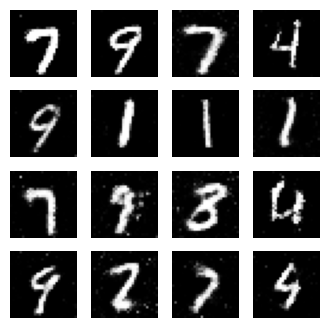

CPU times: user 8min 26s, sys: 40.4 s, total: 9min 7s
Wall time: 8min 11s


In [17]:
%%time
train(train_dataset, EPOCHS)

# 5. 학습 결과 확인

In [18]:
# gif 생성
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('result_img/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

<ipython-input-18-b5fe4cb212ed>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-18-b5fe4cb212ed>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


(-0.5, 27.5, 27.5, -0.5)

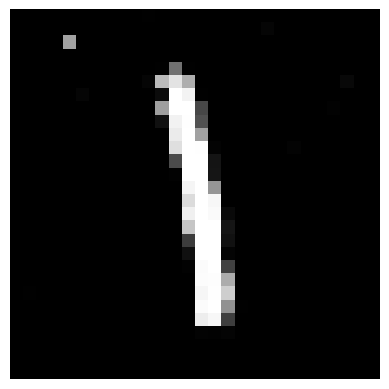

In [27]:
# 이미지 생성해보기
seed2 = tf.random.normal([1, noise_dim])

predictions = generator(seed2, training=False)

plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')